In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust this path to your file's actual location
file_path = '/content/drive/MyDrive/datsaforones/S1_E2_A1.csv'
data = pd.read_csv(file_path)

print("First few rows of the dataset:")
print(data.head())

print("\nDataset information:")
print(data.info())


First few rows of the dataset:
              0             1             2             3             4  \
0  2.719415e-06 -1.046360e-06 -1.214549e-06 -8.354534e-07  2.460952e-06   
1  1.880162e-06 -3.750607e-07 -7.108316e-07  5.075681e-07  2.964534e-06   
2  3.694097e-07  1.135439e-06 -1.717814e-06  1.514890e-06  2.125215e-06   
3 -4.698429e-07  1.638938e-06 -2.389096e-06  1.347311e-06  4.466962e-07   
4 -6.377954e-07  1.281372e-07 -1.214078e-06  1.725329e-07 -1.231823e-06   

          5         6             7             8             9  ...  \
0 -0.000002  0.000005  2.492175e-07 -9.921072e-07  1.968408e-07  ...   
1 -0.000002  0.000003 -7.580247e-07  1.189896e-06 -3.063115e-07  ...   
2 -0.000003  0.000003 -1.933167e-06  1.693299e-06 -9.772646e-07  ...   
3 -0.000004  0.000004 -2.436809e-06 -3.209981e-07 -1.375183e-07  ...   
4 -0.000003  0.000003 -2.436951e-06 -1.495995e-06  1.986270e-07  ...   

       19.1      20.1      21.1    0.4    1.3  0.5  0.6  0.7  0.8  0.9  
0 -40.74927 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281644 entries, 0 to 1281643
Data columns (total 78 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   0       1281644 non-null  float64
 1   1       1281644 non-null  float64
 2   2       1281644 non-null  float64
 3   3       1281644 non-null  float64
 4   4       1281644 non-null  float64
 5   5       1281644 non-null  float64
 6   6       1281644 non-null  float64
 7   7       1281644 non-null  float64
 8   8       1281644 non-null  float64
 9   9       1281644 non-null  float64
 10  10      1281644 non-null  float64
 11  11      1281644 non-null  float64
 12  0.1     1281644 non-null  float64
 13  1.1     1281644 non-null  float64
 14  2.1     1281644 non-null  float64
 15  3.1     1281644 non-null  float64
 16  4.1     1281644 non-null  float64
 17  5.1     1281644 non-null  float64
 18  6.1     1281644 non-null  float64
 19  7.1     1281644 non-null  float64
 20  8.1     1281644 non-null

In [9]:
# Preprocess the data by removing all NaN values
data_cleaned = data.fillna(method='ffill')

print("\nFirst few rows of the cleaned dataset:")
print(data_cleaned.head())

print("\nCleaned dataset information:")
print(data_cleaned.info())


First few rows of the cleaned dataset:
              0             1             2             3             4  \
0  2.719415e-06 -1.046360e-06 -1.214549e-06 -8.354534e-07  2.460952e-06   
1  1.880162e-06 -3.750607e-07 -7.108316e-07  5.075681e-07  2.964534e-06   
2  3.694097e-07  1.135439e-06 -1.717814e-06  1.514890e-06  2.125215e-06   
3 -4.698429e-07  1.638938e-06 -2.389096e-06  1.347311e-06  4.466962e-07   
4 -6.377954e-07  1.281372e-07 -1.214078e-06  1.725329e-07 -1.231823e-06   

          5         6             7             8             9  ...  \
0 -0.000002  0.000005  2.492175e-07 -9.921072e-07  1.968408e-07  ...   
1 -0.000002  0.000003 -7.580247e-07  1.189896e-06 -3.063115e-07  ...   
2 -0.000003  0.000003 -1.933167e-06  1.693299e-06 -9.772646e-07  ...   
3 -0.000004  0.000004 -2.436809e-06 -3.209981e-07 -1.375183e-07  ...   
4 -0.000003  0.000003 -2.436951e-06 -1.495995e-06  1.986270e-07  ...   

       19.1      20.1      21.1    0.4    1.3  0.5  0.6  0.7  0.8  0.9  
0 -

In [14]:
# Check if the cleaned dataset is empty
if data_cleaned.empty:
    raise ValueError("The cleaned dataset is empty. Please check your data and preprocessing steps.")

# Encode categorical columns if any exist
if 'Category' in data_cleaned.columns:
    label_encoder = LabelEncoder()
    data_cleaned['Category'] = label_encoder.fit_transform(data_cleaned['Category'])
    print("\nCategorical columns encoded.")

# Select numerical columns for scaling
numerical_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()

# Check if there are any numerical columns left to scale
if len(numerical_columns) > 0:
    data_cleaned[numerical_columns] = scaler.fit_transform(data_cleaned[numerical_columns])
    print("\nNumerical columns normalized or scaled.")
else:
    print("No numerical columns to scale.")




Numerical columns normalized or scaled.


In [15]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


if 'Category' in data_cleaned.columns:
    label_encoder = LabelEncoder()
    data_cleaned['Category'] = label_encoder.fit_transform(data_cleaned['Category'])

numerical_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
data_cleaned[numerical_columns] = scaler.fit_transform(data_cleaned[numerical_columns])

target_column = '1.1'


X = data_cleaned.drop(columns=[target_column])
y = data_cleaned[target_column]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


model = Sequential()
# Input layer
model.add(Dense(units=256, activation='relu', input_shape=(77,1)))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               19968     
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                

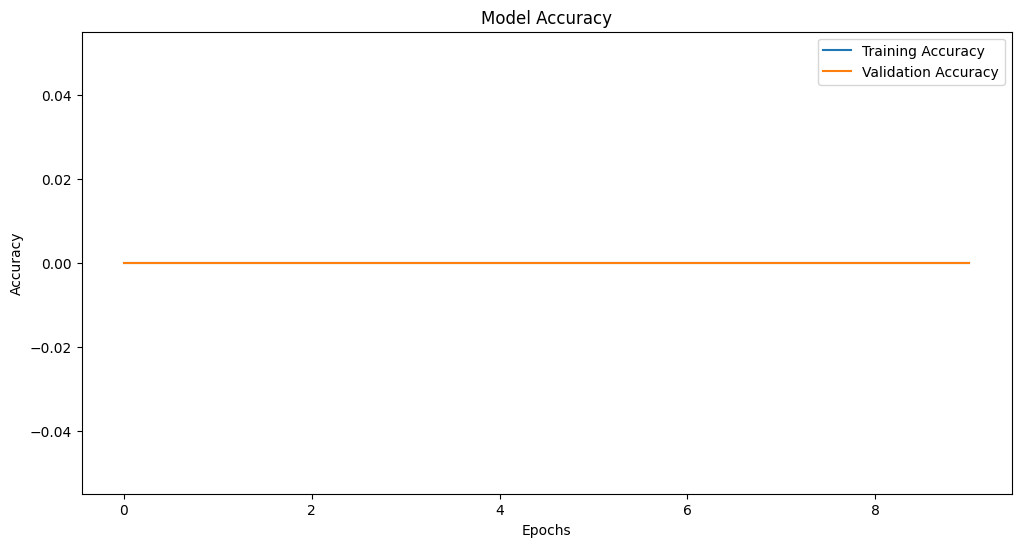

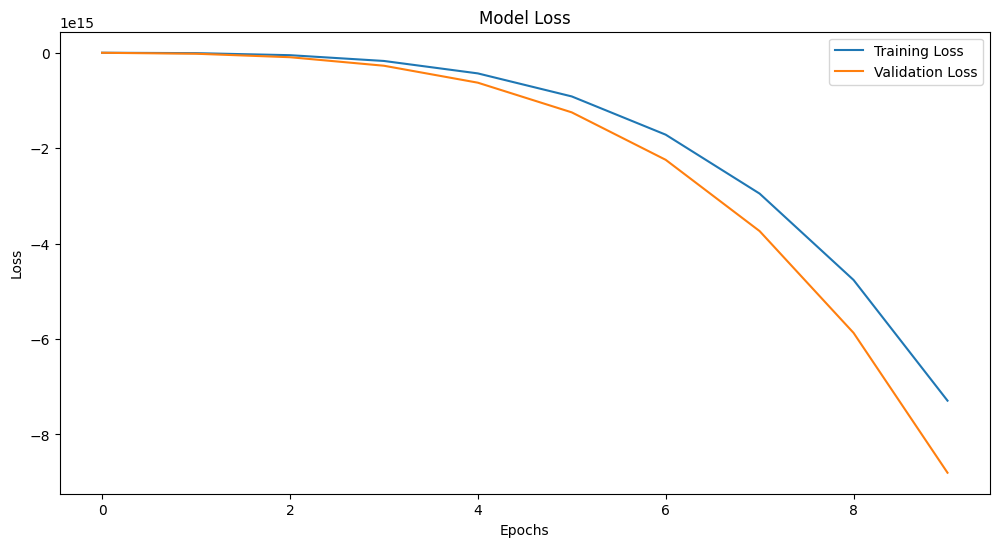

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Trained model saved to /content/drive/MyDrive/trained_model.h5


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Assuming your data has 77 features
input_shape = (77,)

# Building the neural network model
model = Sequential()

# Input layer
model.add(Dense(units=256, activation='relu', input_shape=input_shape))
model.add(Dropout(0.3))

# Hidden layers
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model with adjusted parameters
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model Test Accuracy: {accuracy}")

# Plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model for future use
model_file_path = '/content/drive/MyDrive/trained_model.h5'
model.save(model_file_path)
print(f"\nTrained model saved to {model_file_path}")


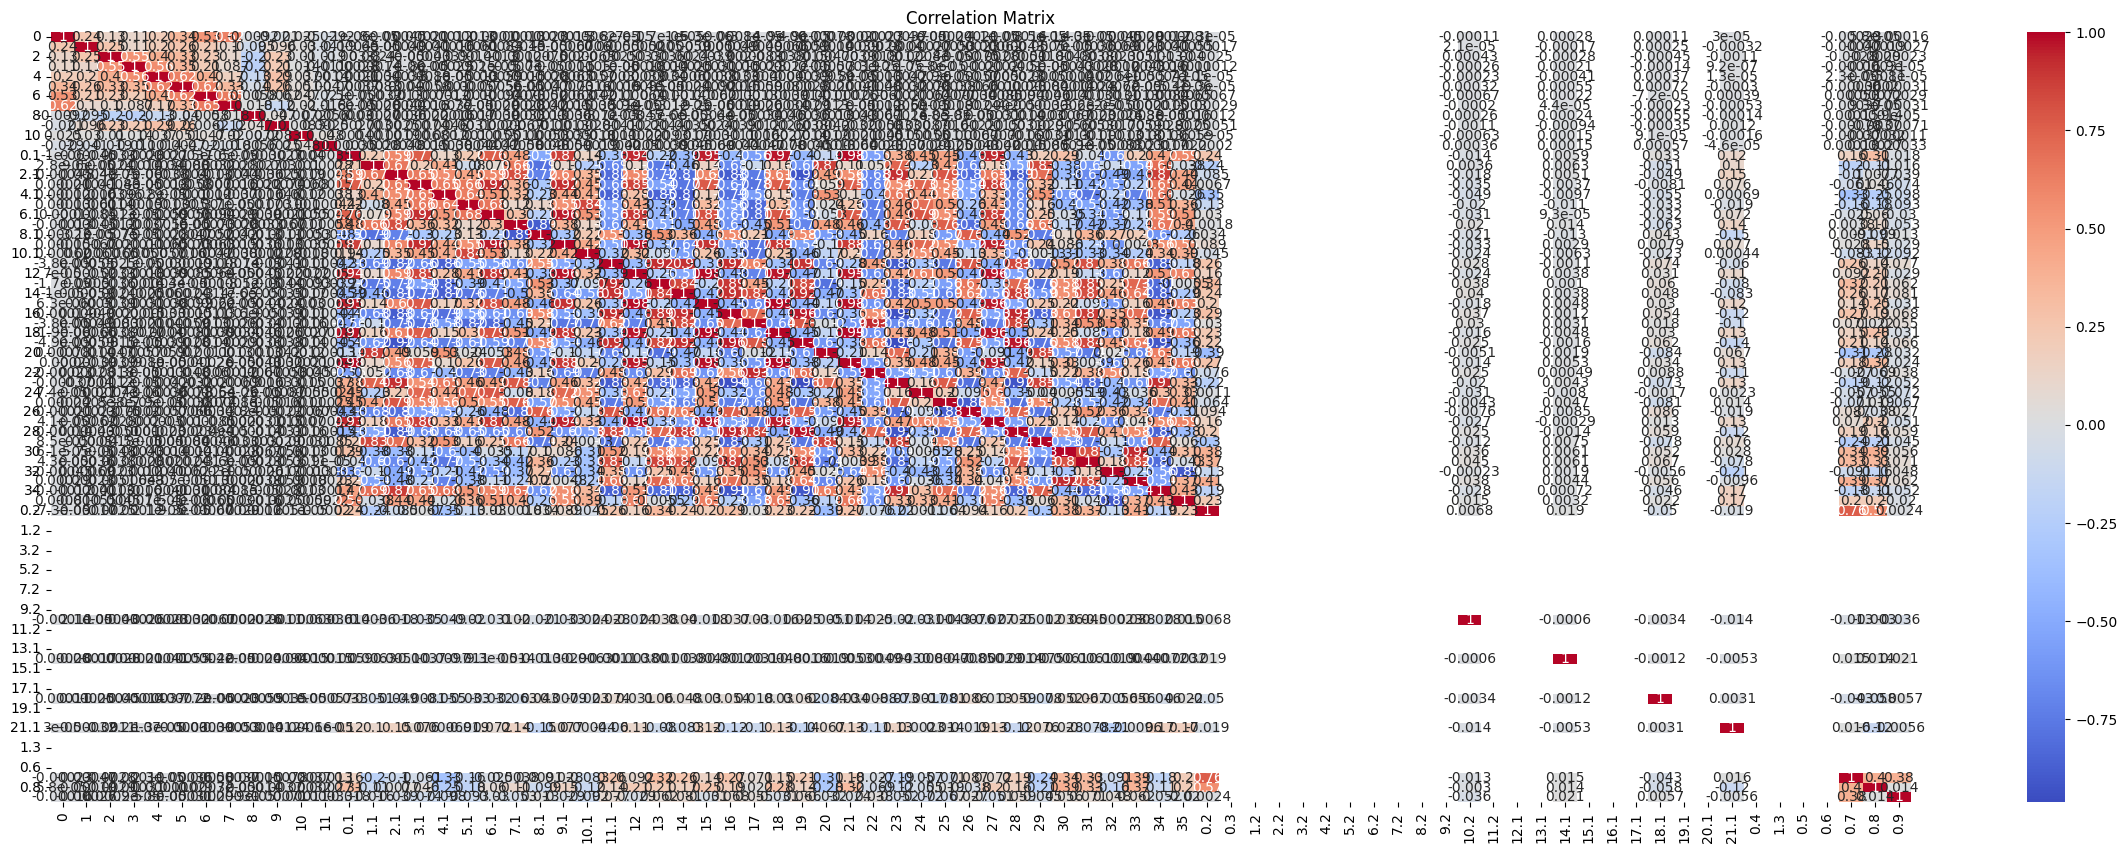

In [ ]:
# Plotting correlation matrix and pairplot
plt.figure(figsize=(30, 10))
sns.heatmap(data_cleaned.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

sns.pairplot(data_cleaned)
plt.show()

In [ ]:





# Plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model for future use
model_file_path = '/content/drive/MyDrive/trained_model.h5'
model.save(model_file_path)
print(f"\nTrained model saved to {model_file_path}")